In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
import copy
%matplotlib inline


SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE/1.2)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [2]:
# Retreive all the data from the meta-data file
#J0600-2020_ASTEP-ANTARCTICA_Rc_measurements.csv : Target calibrated light curve
#J0600-2020_ASTEP-ANTARCTICA_Rc_rawlc.csv : Target and photometric fluxes of reference stars

caldata = ascii.read('../astep/J0600-2020_ASTEP-ANTARCTICA_Rc_measurements.csv')
rawdata = ascii.read('../astep/J0600-2020_ASTEP-ANTARCTICA_Rc_rawlc.csv')
star_info = ascii.read('../astep/CALIB-J0600-2020.csv')
print (star_info)

epoch = rawdata['BJD']
airmass = rawdata['AIRMASS']
sky = rawdata['SKY']
star_mag = star_info['MAG']

J0600_flux = rawdata['TFLUX']
J0600_coords = [90.00316332976436, -31.007910088843165]

flux = []
for i in range(1,6):
    flux.append(rawdata['CFLUX'+str(i)])
flux = np.array(flux).T

 NB   UCAC4     MAG    XC     YC   APER
--- ---------- ----- ------ ------ ----
 C1 296-008997 12.38 2033.4 2385.8    9
 C2 296-009022 12.33 1679.0 2584.5    9
 C3 296-009008  12.7 1838.4 2160.8    9
 C4 295-008892 12.42 2051.6 1756.3    9
 C5 295-008877 13.38 2198.5 1500.5    9


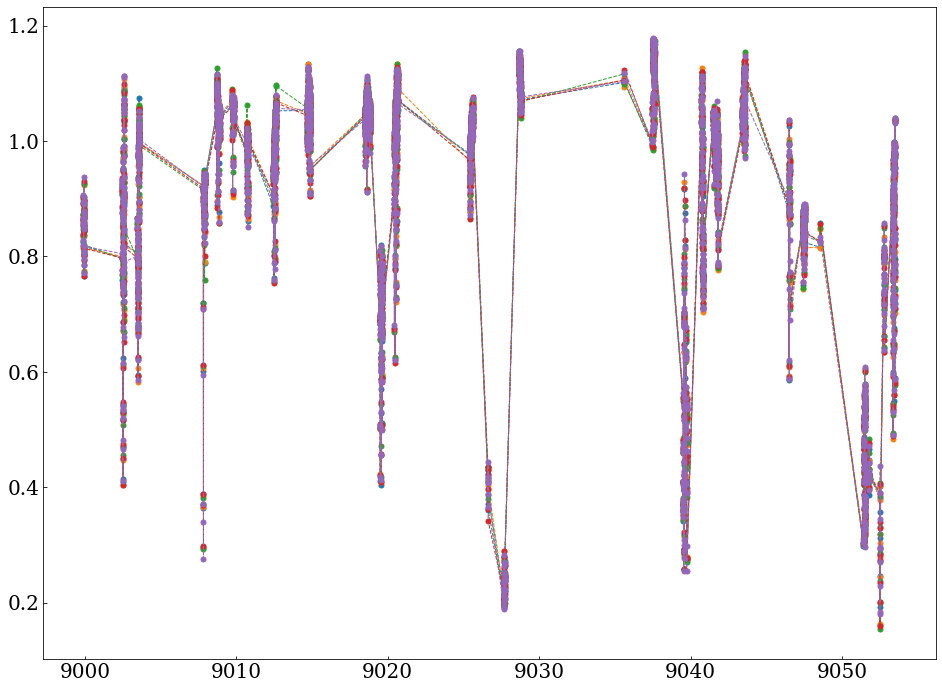

In [3]:
plt.figure(figsize=(16,12))
for s in range(5):
    plt.errorbar(epoch,flux[:,s]/np.nanmedian(flux[:,s]),yerr=np.sqrt(flux[:,s])/np.nanmedian(flux[:,s]),
                 fmt='--.',markersize=10,linewidth=1)
#plt.xlim(9019.4,9019.8)
plt.show()

In [4]:
star_coords_tmp = np.array([
    [6 + 19.491336/3600, -(30 + 56/60 + 22.20720/3600)],
    [6 + 45.078216/3600, -(30 + 53/60 + 13.82208/3600)],
    [6 + 33.819120/3600, -(30 + 59/60 + 50.89200/3600)],
    [6 + 18.551304/3600, -(31 +  6/60 + 11.49732/3600)],
    [6 + 08.019888/3600, -(31 + 10/60 + 11.48808/3600)]
])
star_coords = copy.copy(star_coords_tmp)
star_coords[:,0] = star_coords[:,0] /24 * 360 # from hr to degrees

plt.figure(figsize=(8,8))
for s in range(5):
    plt.scatter(star_coords[s,0],star_coords[s,1],label=str(s+1))
plt.scatter([90.00316332976436], [-31.007910088843165], c='black')
plt.legend()
plt.ylim(-31.20,-30.85)
plt.xlim(90.25,89.90)
plt.xlabel("Right Ascention")
plt.ylabel("Declination")
plt.show()

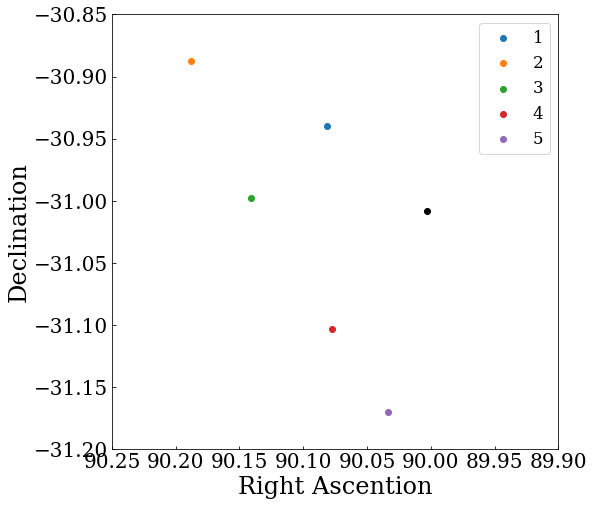

In [5]:
plt.figure(figsize=(8,8))
for s in range(5):
    plt.scatter(star_coords[s,0],star_coords[s,1],label=str(s+1))
plt.scatter([90.00316332976436], [-31.007910088843165], c='black')
plt.legend()
plt.ylim(-31.20,-30.85)
plt.xlim(90.25,89.90)
plt.xlabel("Right Ascention")
plt.ylabel("Declination")
plt.show()

# Trying the differential photometry atmospheric correction

In [6]:
# Let's skip this first two steps


In [7]:
initialw = np.nanmedian(flux,axis=0)
print (initialw)
    
def ALC_func(F,ep, inw, w):
    tmp = []
    
    for e in range(len(ep)):
        noNaN = np.isnan(F[e]) == False
        ALC_i = np.sum(((F[e]*w)/(inw))[noNaN]) / np.sum(w[noNaN])
        tmp.append(ALC_i)
        
    return np.array(tmp)

ALC = ALC_func(flux,epoch, initialw, initialw)
print (ALC)

[302707.2 293392.5 207422.5 269549.1 120918.5]
[0.82060919 0.86873054 0.88722433 ... 0.98653004 0.73664708 1.03551094]


In [8]:
def weight_func(F, ep, inw, ALC):
    
    w_ij = []
    for e in range(len(ep)):
        w_j = ((F[e]/inw) *(1/(ALC[e])))
        w_ij.append(w_j)
    w_ij = np.array(w_ij)
    
    return (1/np.sqrt(np.nanmean((w_ij-np.nanmean(w_ij,axis=0))**2,axis=0)))**2 

#neww = {}
#for f in filt:
#    neww[f] = weight_func(newflux[f],corepoch[f],initialw[f],ALC[f])

In [9]:
i = 0

test = []

while i < 100:
    i += 1
    
    neww = weight_func(flux,epoch,initialw,ALC)
    test.append(neww)
    
    ALC = ALC_func(flux,epoch, initialw, neww)
    


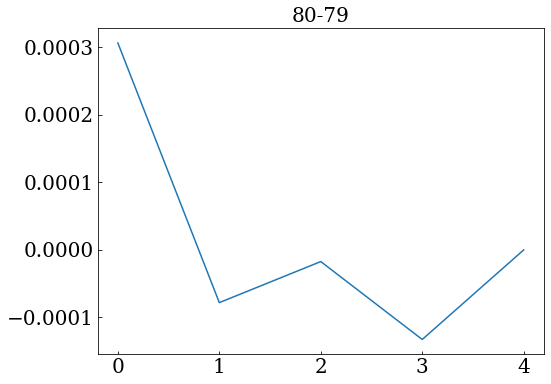

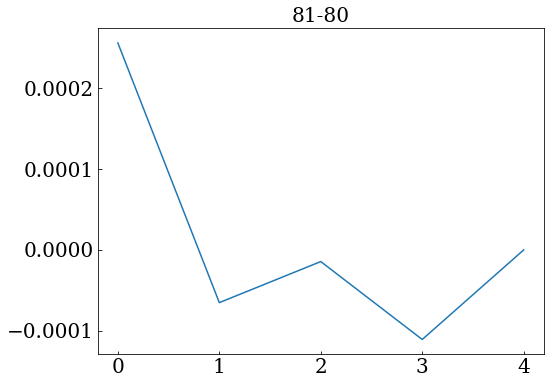

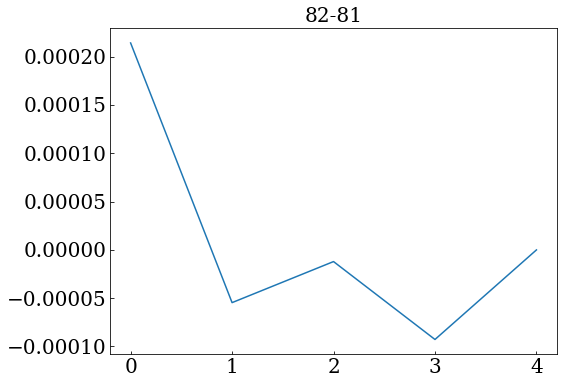

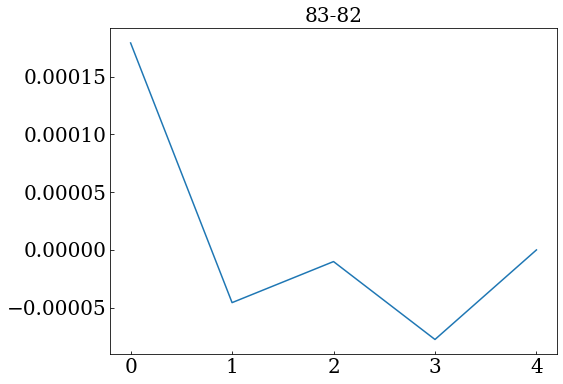

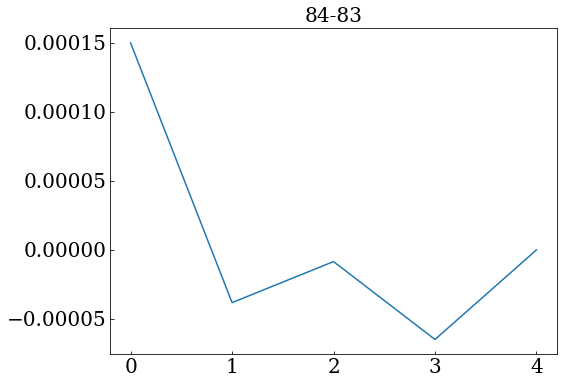

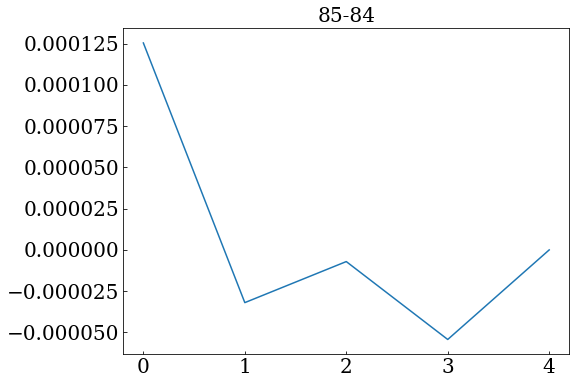

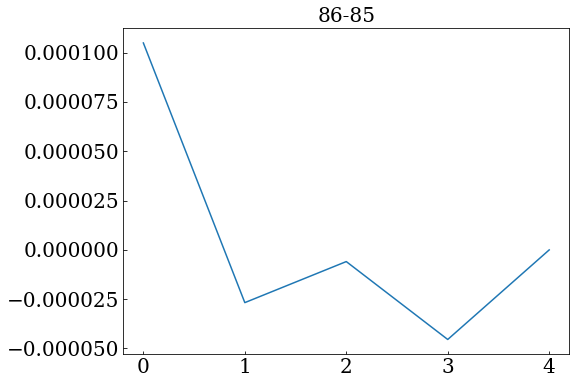

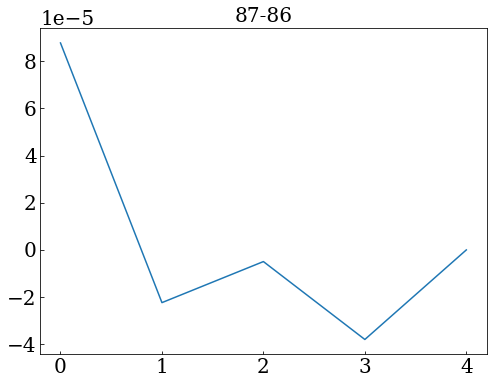

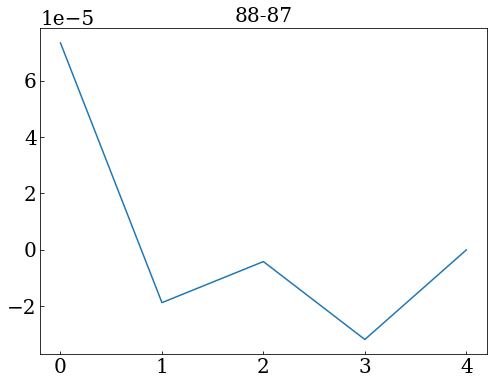

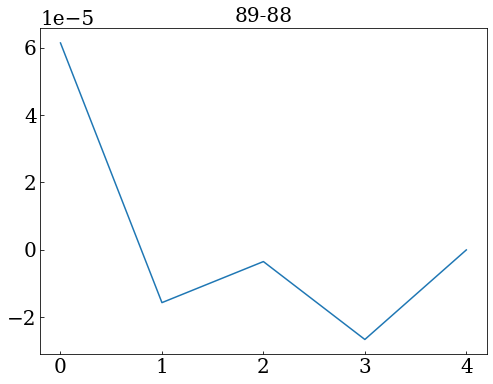

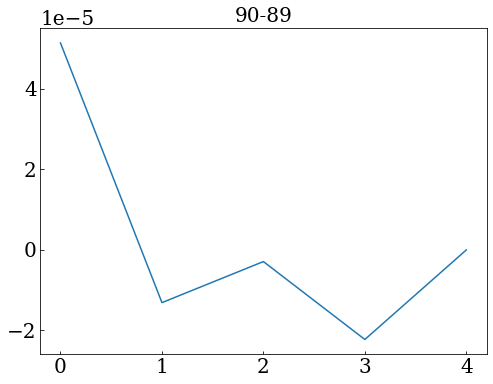

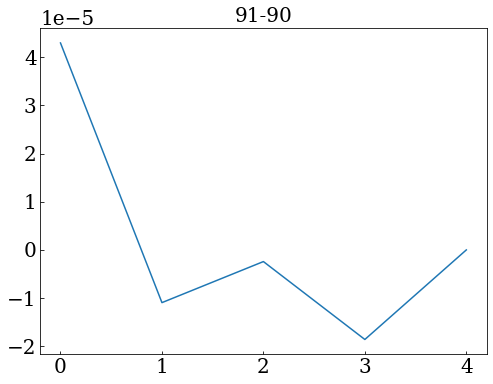

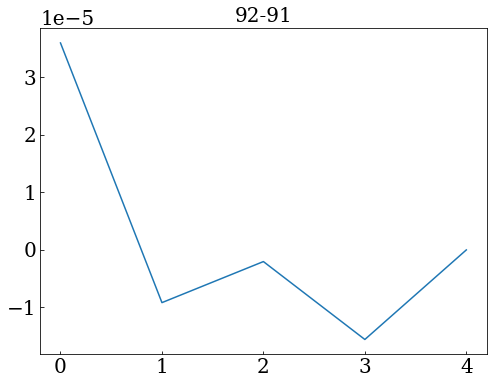

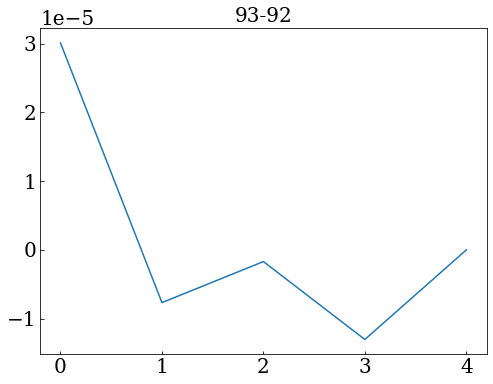

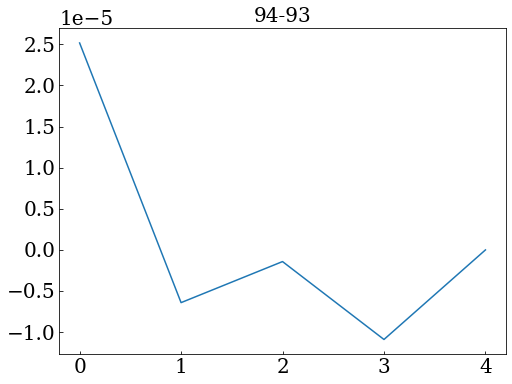

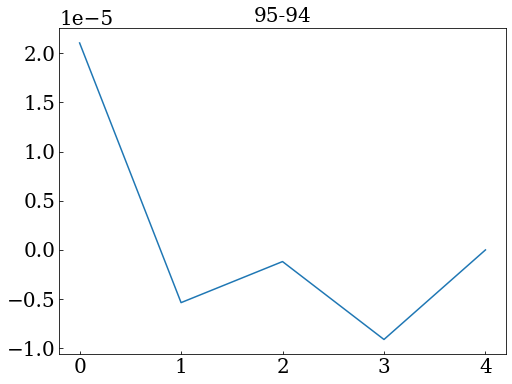

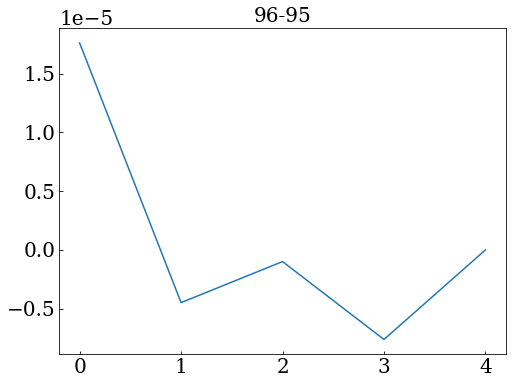

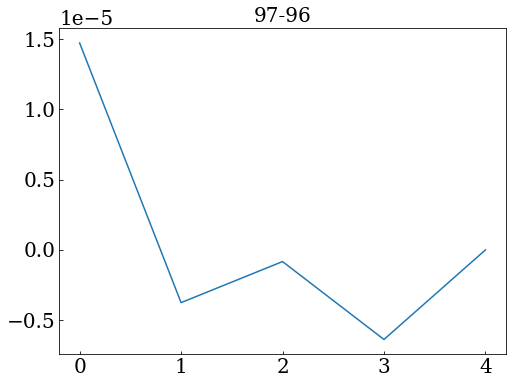

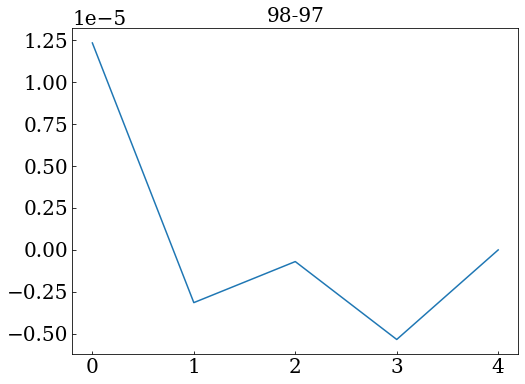

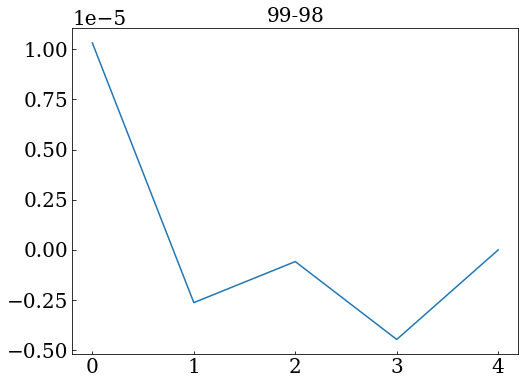

In [10]:
for i in range(80,100):
    plt.plot(test[i]-test[i-1])
    plt.title(str(i)+"-"+str(i-1))
    plt.show()

In [11]:
def RMS(arr):
    return np.sqrt(np.nanmean((np.nanmean(arr)-arr)**2))

In [12]:
tmp = []
for s in range(5):
    tmp.append(RMS(flux[:,s]/ALC))
print (np.array(tmp))
print (np.shape(np.array(tmp)))

[1785.31399246 2076.68620916 1619.10979096 1789.97635809 1561.0537465 ]
(5,)


In [13]:
# Check if wights converge within 1e-5


#for i in range(1,50):
#    plt.plot(np.array(test[i-1])-np.array(test[i]))
    #plt.yscale('log')
#plt.ylim([-1e-5,1e-5])
#    plt.show()


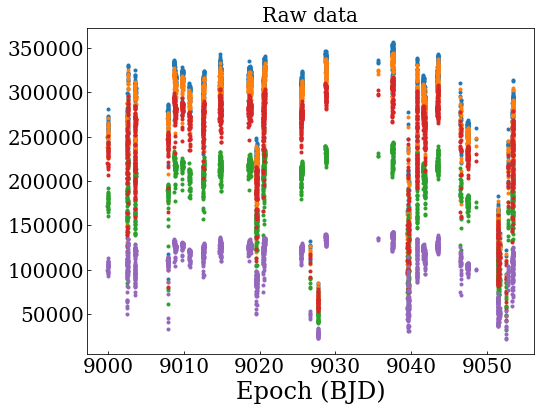

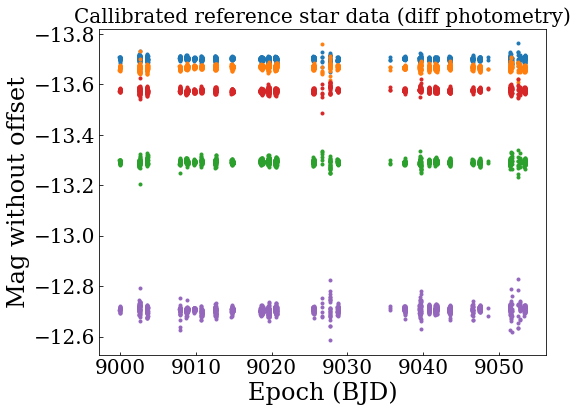

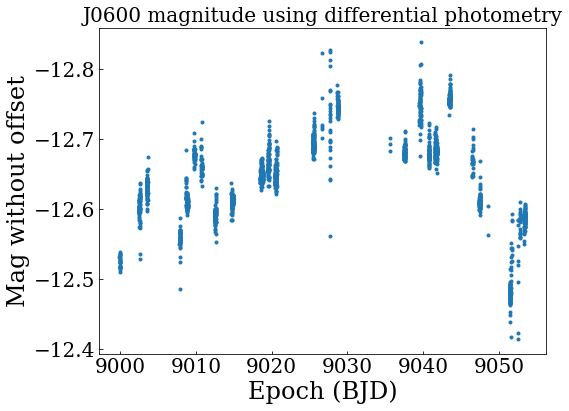

In [14]:
for s in range(5):
    plt.errorbar(epoch,flux[:,s],fmt='.')
#plt.gca().invert_yaxis()
plt.title("Raw data")
plt.xlabel("Epoch (BJD)")
plt.show()

for s in range(5):
    plt.errorbar(epoch,-2.5*np.log10(flux[:,s]/ALC),fmt='.')
    
plt.gca().invert_yaxis()
plt.title("Callibrated reference star data (diff photometry)")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.show()

plt.errorbar(epoch,-2.5*np.log10(J0600_flux/ALC),fmt='.')
plt.gca().invert_yaxis()
plt.title("J0600 magnitude using differential photometry")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.show()

In [15]:
stdcl_mask = []

double_normalised_flux = (((flux.T)/ALC).T)/np.nanmedian((((flux.T)/ALC).T),axis=0)
sig = np.nanstd(double_normalised_flux,axis=1)
med = np.nanmedian(double_normalised_flux,axis=1)

print (sig)
print (med)

sigcl_flux = copy.deepcopy(flux)
#sigcl_fluxerr = copy.deepcopy(fluxerr)
for e in range(len(epoch)):
    sigclip_mask = np.abs(double_normalised_flux[e]-med[e]) > 2*sig[e]
    sigcl_flux[e][sigclip_mask] = np.NaN
    #sigcl_fluxerr[e][sigclip_mask] = np.NaN
print (np.sum(np.isnan(flux),axis=0))
print (np.shape(flux))
print (np.sum(np.isnan(sigcl_flux),axis=0))

[0.0057433  0.00634049 0.0090448  ... 0.00678182 0.00881676 0.00286048]
[0.99750965 0.9995927  1.00659229 ... 1.00024781 0.9940781  1.00168633]
[0 0 0 0 0]
(1933, 5)
[ 83 120 124 108 268]


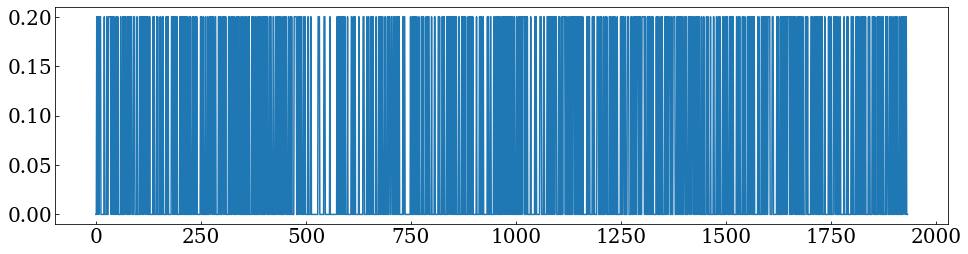

0.0727366787377134


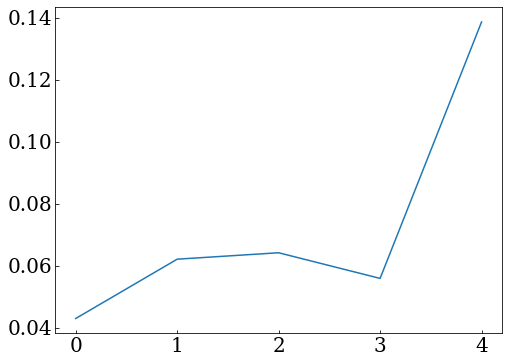

In [16]:
plt.figure(figsize=(16,4))
plt.plot(np.sum(np.isnan(sigcl_flux),axis=1)/5)
plt.show()
print (np.sum(np.isnan(sigcl_flux))/len(sigcl_flux[:,0])/5)
plt.plot(np.sum(np.isnan(sigcl_flux),axis=0)/len(epoch))
plt.show()

In [17]:
medflux2 = np.nanmedian(sigcl_flux,axis=0)
final_weight = copy.copy(neww)
print (medflux2)

[303030.7 293806.6 207802.1 269387.3 120736. ]


In [18]:
ALC_final = {}

i = 0

test = []

while i < 65:
    i += 1
    
    ALC_final = ALC_func(sigcl_flux, epoch, medflux2, final_weight)


    final_weight = weight_func(sigcl_flux, epoch, medflux2, ALC_final)
    test.append(final_weight)

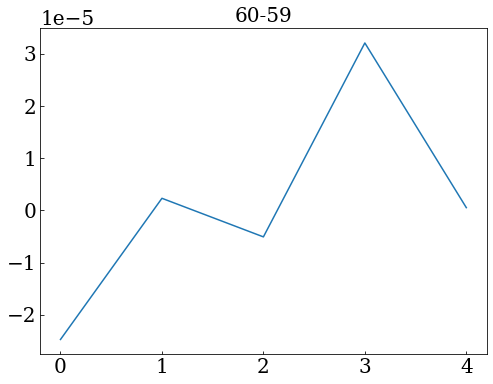

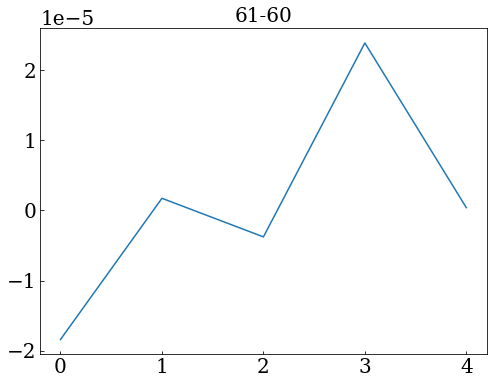

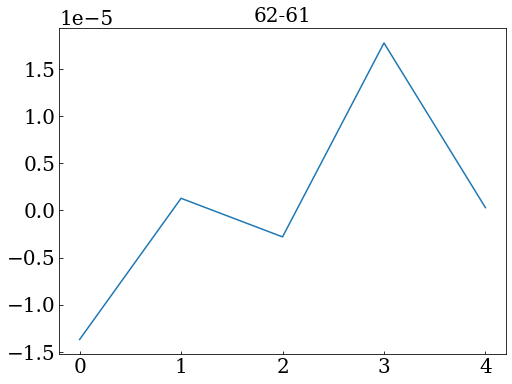

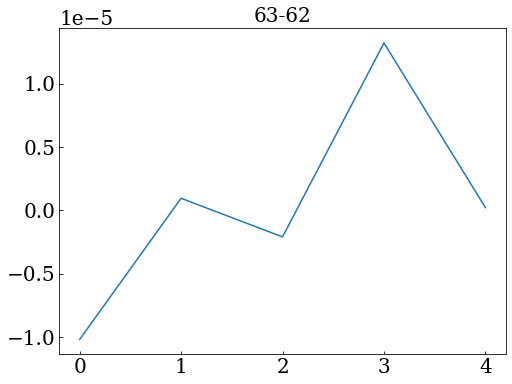

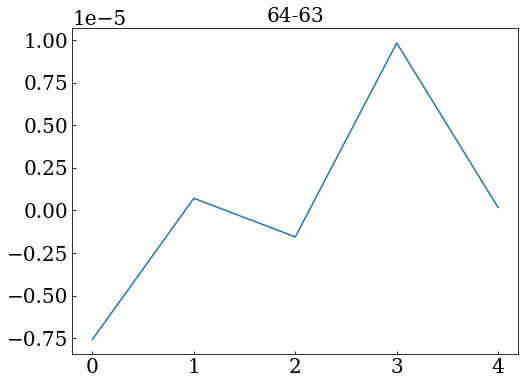

In [19]:
for i in range(60,65):
    plt.plot(test[i]-test[i-1])
    plt.title(str(i)+"-"+str(i-1))
    plt.show()

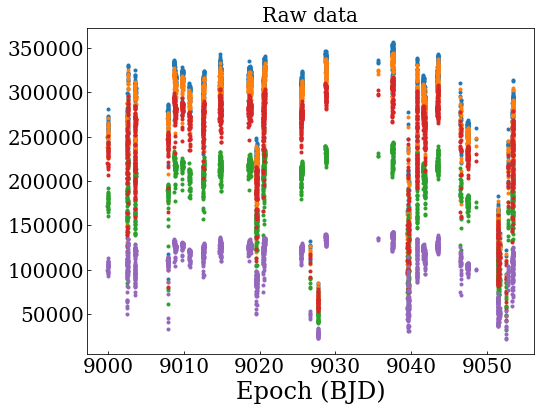

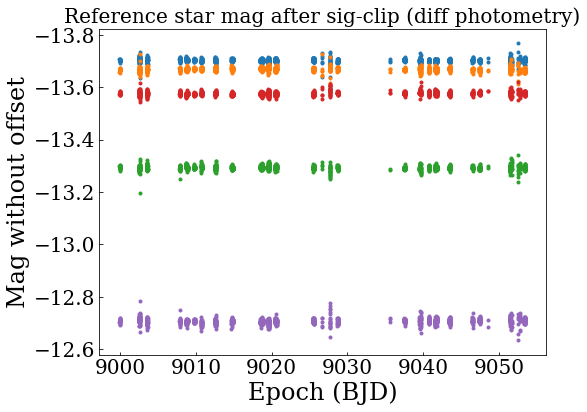

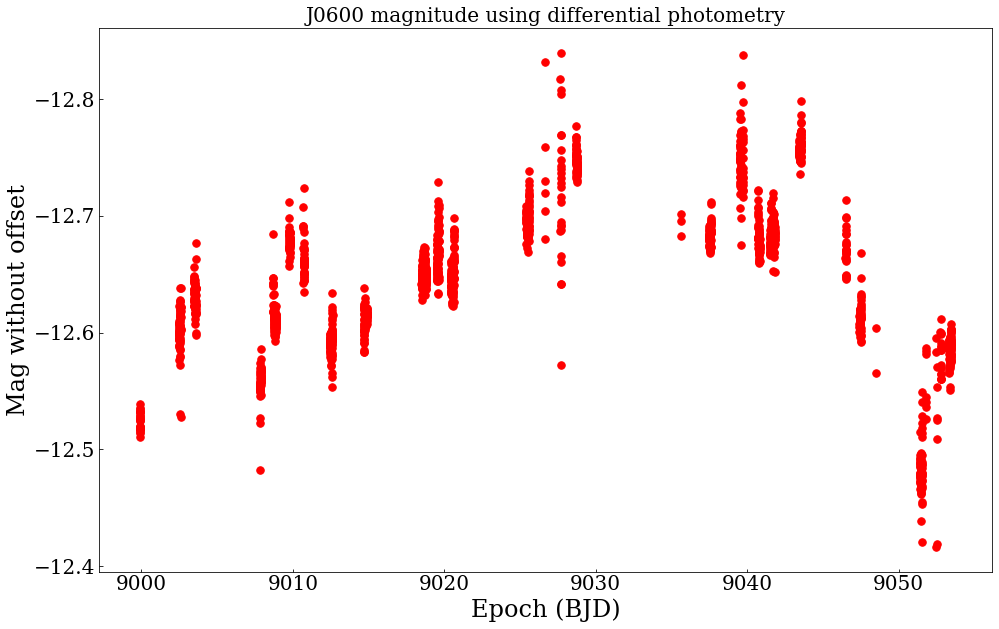

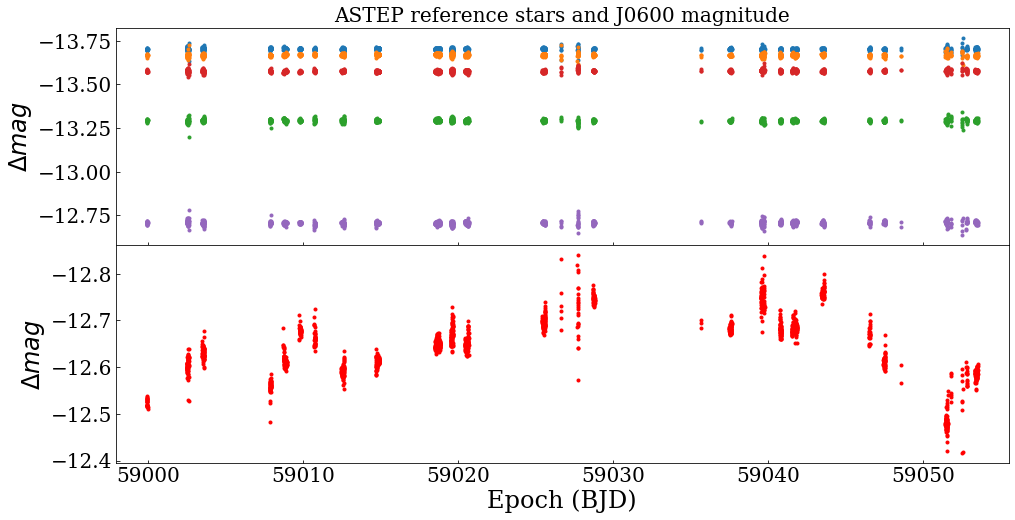

In [78]:
for s in range(5):
    plt.errorbar(epoch,flux[:,s],fmt='.')
#plt.gca().invert_yaxis()
plt.title("Raw data")
plt.xlabel("Epoch (BJD)")
plt.show()

for s in range(5):
    plt.errorbar(epoch,-2.5*np.log10((sigcl_flux[:,s]/ALC_final)),fmt='.')
plt.gca().invert_yaxis()
plt.title("Reference star mag after sig-clip (diff photometry)")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.show()

plt.figure(figsize=(16,10))
plt.errorbar(epoch,-2.5*np.log10(J0600_flux/ALC_final),fmt='.',c='r',markersize=15,label='after sig-clip')
plt.gca().invert_yaxis()
plt.title("J0600 magnitude using differential photometry")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
#plt.legend(loc=3)
#plt.xlim(9018,9022)
plt.show()

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
fig.set_figheight(8)
fig.set_figwidth(16)
axs[0].set_title('ASTEP reference stars and J0600 magnitude')
for s in range(5):
    axs[0].errorbar(epoch+5e4,-2.5*np.log10((sigcl_flux[:,s]/ALC_final)),fmt='.')
axs[0].set_ylabel("$\Delta mag$")
axs[0].invert_yaxis()

axs[1].errorbar(epoch+5e4, -2.5*np.log10(J0600_flux/ALC_final),fmt='.',c='r')
axs[1].invert_yaxis()
axs[1].set_ylabel("$\Delta mag$")
axs[1].set_xlabel("Epoch (BJD)")
axs[1].set_xlim(np.min(epoch)-2+5e4,5e4+2+np.max(epoch))

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

[302820.06468619 293539.88639349 207524.81975036 269356.94154707
 121055.09185234]
0.008449740503807843


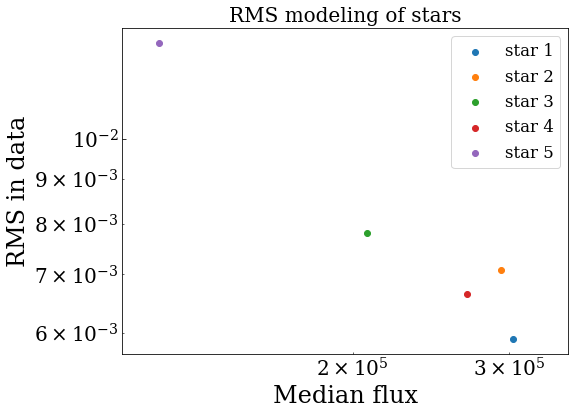

In [21]:
# Try to look voor variable stars or something
#from scipy import optimize

#def starRMS_model(F, a,b,c):
#    print ([a,b,c])
#    return np.log(a*np.sqrt((1/F) + (b/(F**2)) + c))


tmp1 = np.median(flux.T/ALC,axis=1)
tmp2 = RMS((flux/tmp1).T/ALC)
print (tmp1)
print (tmp2)
#popt, pcov = optimize.curve_fit(starRMS_model, tmp1, tmp2,p0=[2.5, 1e5, 1e-5])


for s in range(5):
    plt.scatter(tmp1[s],RMS(((flux/tmp1).T/ALC)[s]),label="star "+str(s+1))
plt.title("RMS modeling of stars")
plt.xlabel("Median flux")
plt.ylabel("RMS in data")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1.1e5,3.5e5)
plt.show()



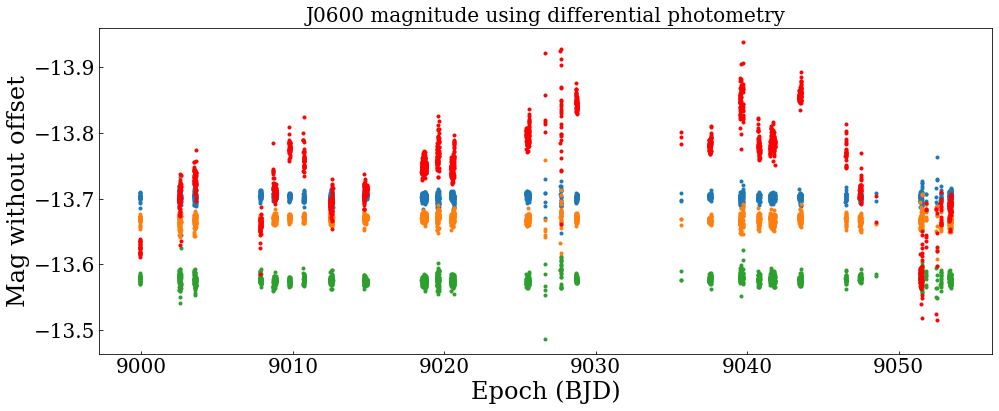

In [22]:
plt.figure(figsize=(16,6))
for s in [0,1,3]:
    plt.errorbar(epoch,-2.5*np.log10((flux[:,s]/ALC)),fmt='.',label=s)   
plt.errorbar(epoch,-2.5*np.log10(J0600_flux/ALC)-1.1,fmt='.',c='r')#,markersize=10, label='before sig-clip')
plt.gca().invert_yaxis()
plt.title("J0600 magnitude using differential photometry")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
#plt.xlim(9018,9022)
#plt.legend()
#plt.xlim(9024,9030)
l = 5*2
#plt.xlim(8995+l,9000+l)
plt.show()

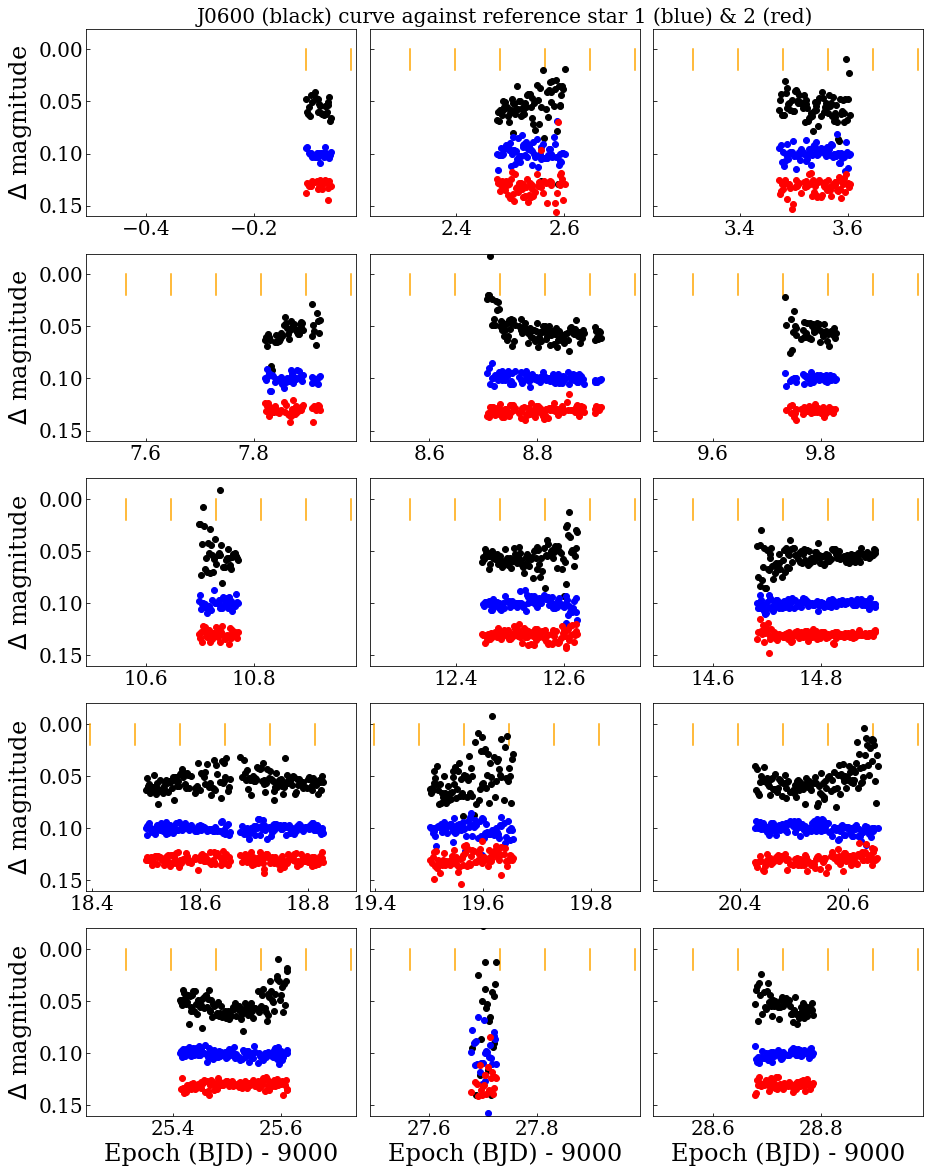

In [84]:
i_lim = 5
j_lim = 3
fig, axs = plt.subplots(i_lim,j_lim,gridspec_kw={'hspace': 0.2,'wspace':0.05}, sharey=True)#, 
fig.set_figheight(4*i_lim)
fig.set_figwidth(5*j_lim)
axs[0,1].set_title("J0600 (black) curve against reference star 1 (blue) and 2 (red)")
#fig.tight_layout()

lims = np.array([
    [[-0.5,  0],     [2.25,  2.75],  [3.25, 3.75]],
    [[7.5,   8],     [8.5,   9],     [9.5,  10]],
    [[10.5,  11],    [12.25, 12.75], [14.5, 15]],
    [[18.4,  18.9],  [19.4,  19.9],    [20.25, 20.75]],
    [[25.25, 25.75], [27.5,  28],    [28.5, 29]]
])-0.01

def windowplt(i,j,x,y,offset,c,mask,a):
    axs[i,j].errorbar(x,y - np.nanmedian(y[mask]) + offset, fmt='o',c=c,alpha=a)

for i in range(i_lim):
    for j in range(j_lim):
        m1 = epoch-9000 > lims[i,j,0]
        m2 = epoch-9000 < lims[i,j,1]
        #windowplt(i,j, epoch-9000, -2.5*np.log10(J0600_flux/ALC), 0.055, 'black', m1*m2,1)
        windowplt(i,j, epoch-9000, -2.5*np.log10(J0600_flux/ALC_final), 0.055, 'black', m1*m2,1)
        s = 0
        windowplt(i,j, epoch-9000, -2.5*np.log10(sigcl_flux[:,s]/ALC_final), 0.10, 'blue', m1*m2,1)
        s = 1
        windowplt(i,j, epoch-9000, -2.5*np.log10(sigcl_flux[:,s]/ALC_final), 0.13, 'red', m1*m2,1)
        
        for x in range(int((epoch[-1]-epoch[0])*12)):
            axs[i,j].plot([epoch[0]+x/12-9000]*2,[0,.02],c='orange')
        
        #axs[i,j].plot(epoch-9000,-2.5*np.log10(J0600_flux/ALC)-np.nanmedian((-2.5*np.log10(J0600_flux/ALC))[m1*m2])+0.03,
        #         marker='.',linestyle='',markersize=10,c='r')
        #s = 0
        #axs[i,j].plot(epoch-9000,-2.5*np.log10(flux[:,s]/ALC)-np.nanmedian((-2.5*np.log10(flux[:,s]/ALC))[m1*m2])+0.08,
        #         marker='.',linestyle='',markersize=10,c='blue')
        #s = 1
        #axs[i,j].plot(epoch-9000,-2.5*np.log10(flux[:,s]/ALC)-np.nanmedian((-2.5*np.log10(flux[:,s]/ALC))[m1*m2])+0.12,
        #         marker='.',linestyle='',markersize=10,c='orange')
        
        axs[i,j].set_xlim(lims[i,j])
        axs[i,j].set_ylim([-.02,0.16])
        #axs[i,j].set_ylim([-0.05,0.35])
        axs[i,j].invert_yaxis()
        
        if j == 0:
            axs[i,j].set_ylabel('$\Delta$ magnitude')
        if i == i_lim-1:
            axs[i,j].set_xlabel('Epoch (BJD) - 59000')

#for ax in axs.flat:
#    ax.set(xlabel='Epoch (BJD)', ylabel='$\Delta$ magnitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

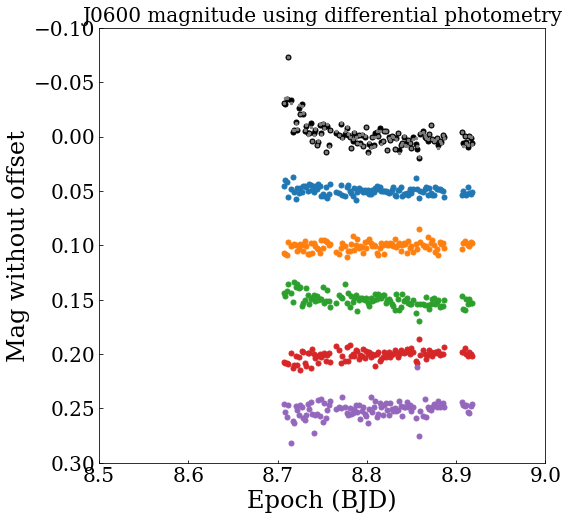

In [24]:
i,j = 1,1

m1 = epoch-9000 > lims[i,j,0]
m2 = epoch-9000 < lims[i,j,1]

plt.figure(figsize=(8,8))
plt.plot(epoch-9000,-2.5*np.log10(J0600_flux/ALC)-np.nanmedian((-2.5*np.log10(J0600_flux/ALC))[m1*m2]),
                 marker='.',linestyle='',markersize=10,c='black')
plt.plot(epoch-9000,-2.5*np.log10(J0600_flux/ALC_final)-np.nanmedian((-2.5*np.log10(J0600_flux/ALC_final))[m1*m2]),
                 marker='.',linestyle='',markersize=5,c='grey')
for s in range(5):#[0,1,3]:
    plt.plot(epoch-9000,-2.5*np.log10(flux[:,s]/ALC)-np.nanmedian((-2.5*np.log10(flux[:,s]/ALC))[m1*m2])+0.05*(s+1),
                 marker='.',linestyle='',markersize=10)

plt.title("J0600 magnitude using differential photometry")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.xlim(lims[i,j])
plt.ylim(-0.1,0.3)
plt.gca().invert_yaxis()
plt.show()

# Merge datapoints that are taken close together for higher accuracy

643.1602319999874


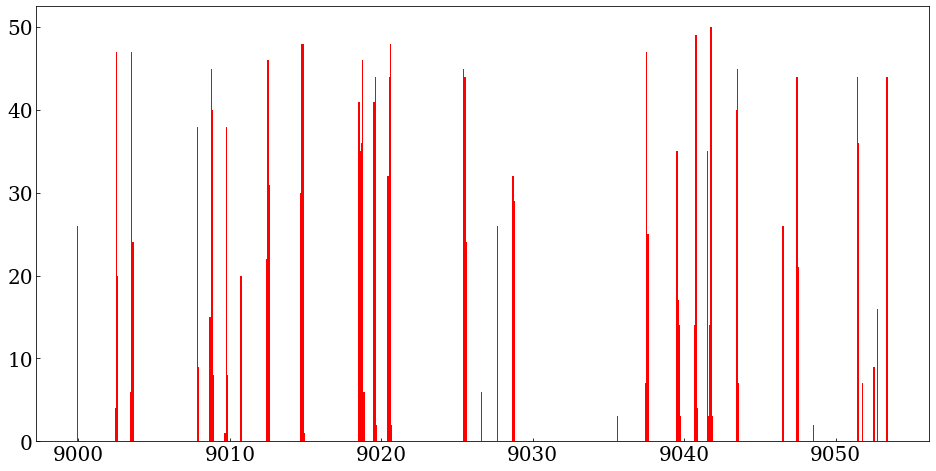

In [25]:
binsize = 2 # width of bins in units of hours

print ((np.max(epoch)-np.min(epoch))*24/binsize)
plt.figure(figsize=(16,8))
#plt.hist(epoch,bins=60)
#plt.hist(epoch,bins=300)
#plt.hist(epoch,bins=int(((np.max(epoch)-np.min(epoch))*12)),color='blue') #bins of an hour
plt.hist(epoch,bins=int(((np.max(epoch)-np.min(epoch))*24/binsize)),color='red') #bins of an hour
#plt.ylim(0,5)
plt.show()

[26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  4 47 20  0  0  0  0  0  0  0  0  0  6 47 24  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 38
  9  0  0  0  0  0  0  0  0 15 45 40  8  0  0  0  0  0  0  0  0  1 38  8
  0  0  0  0  0  0  0  0  0 20 20  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 22 46 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 30 48 48  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 41 35 36 46  6  0  0  0  0  0  0  0 41 44  2  0  0
  0  0  0  0  0  0 32 44 48  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 45 44 24  0  0  0
  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0

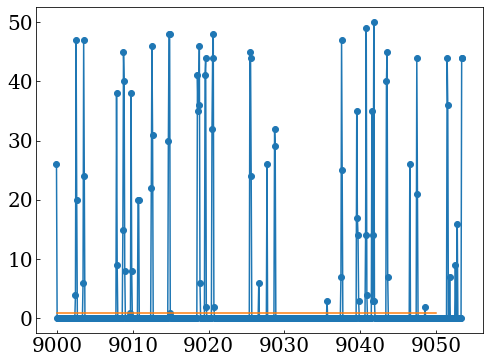

In [26]:
b = int((np.max(epoch)-np.min(epoch))*24/binsize)


num, bins =  np.histogram(epoch, bins=b)
print (num)
print (bins)

plt.plot((bins[:-1]+bins[1:])/2,num,marker='o')
plt.plot([9000,9050],[1,1])
plt.show()

In [85]:
#MASKS = np.ones((len(num),len(epoch)))
corepoch = (bins[1:] + bins[:-1])/2

cormag = []
cormagerr = []
cormag2 = []
cormagerr2 = []
J0600cormag = []
J0600cormagerr = []
J0600cormag2 = []
J0600cormagerr2 = []
for e in range(len(corepoch)):
    m1 = epoch > bins[e]
    m2 = epoch < bins[e+1]
    
    #print (np.shape(np.nanmean(flux[m1*m2],axis=0)))
    
    cormag.append(np.nanmean((-2.5*np.log10(flux.T/ALC).T)[m1*m2],axis=0))
    cormagerr.append(np.nanstd((-2.5*np.log10(flux.T/ALC).T)[m1*m2],axis=0))
    J0600cormag.append(np.nanmean((-2.5*np.log10(J0600_flux.T/ALC).T)[m1*m2],axis=0))
    J0600cormagerr.append(np.nanstd((-2.5*np.log10(J0600_flux.T/ALC).T)[m1*m2],axis=0))
    
    cormag2.append(np.nanmean((-2.5*np.log10(sigcl_flux.T/ALC_final).T)[m1*m2],axis=0))
    cormagerr2.append(np.nanstd((-2.5*np.log10(sigcl_flux.T/ALC_final).T)[m1*m2],axis=0))
    J0600cormag2.append(np.nanmean((-2.5*np.log10(J0600_flux.T/ALC_final).T)[m1*m2],axis=0))
    J0600cormagerr2.append(np.nanstd((-2.5*np.log10(J0600_flux.T/ALC_final).T)[m1*m2],axis=0))


cormag = np.array(cormag)
cormagerr = np.array(cormagerr)
J0600cormag = np.array(J0600cormag)
J0600cormagerr = np.array(J0600cormagerr)

cormag2 = np.array(cormag2)
cormagerr2 = np.array(cormagerr2)
J0600cormag2 = np.array(J0600cormag2)
J0600cormagerr2 = np.array(J0600cormagerr2)

<ipython-input-85-83d1d8399d48>:18: RuntimeWarning: Mean of empty slice
  cormag.append(np.nanmean((-2.5*np.log10(flux.T/ALC).T)[m1*m2],axis=0))
/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-85-83d1d8399d48>:20: RuntimeWarning: Mean of empty slice
  J0600cormag.append(np.nanmean((-2.5*np.log10(J0600_flux.T/ALC).T)[m1*m2],axis=0))
<ipython-input-85-83d1d8399d48>:23: RuntimeWarning: Mean of empty slice
  cormag2.append(np.nanmean((-2.5*np.log10(sigcl_flux.T/ALC_final).T)[m1*m2],axis=0))
<ipython-input-85-83d1d8399d48>:25: RuntimeWarning: Mean of empty slice
  J0600cormag2.append(np.nanmean((-2.5*np.log10(J0600_flux.T/ALC_final).T)[m1*m2],axis=0))


In [49]:
#tried to find magnitude ZP

from scipy import optimize
def zeropoint(m,a):
    return m + a

ZP_real = []
# An overall zeropoint
popt, pcov = optimize.curve_fit(zeropoint, np.nanmedian(cormag,axis=0), star_mag,sigma=final_weight)


ZP_real = np.array(popt[0])
print (ZP_real)
#plt.figure(figsize=(6,6))
#plt.plot(np.linspace(np.min(gaia_mag[f]),np.max(gaia_mag[f])),np.linspace(np.min(gaia_mag[f]),np.max(gaia_mag[f])))
#plt.scatter(gaia_mag[f][c_mask[f]], -2.5*np.log10(medflux3[f])+ZP_real[f])
#plt.show()


26.051289012828153


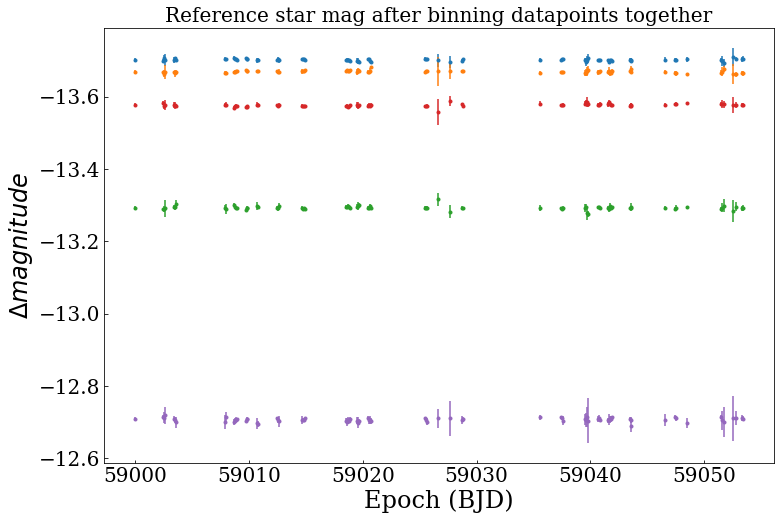

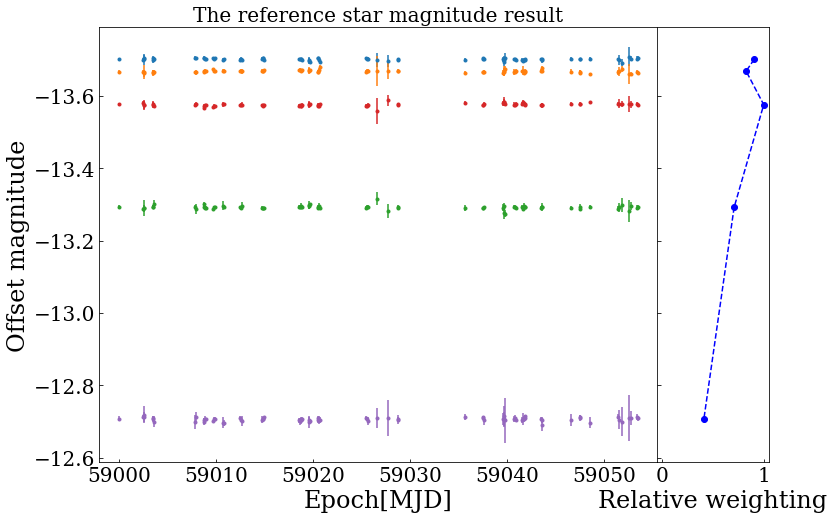

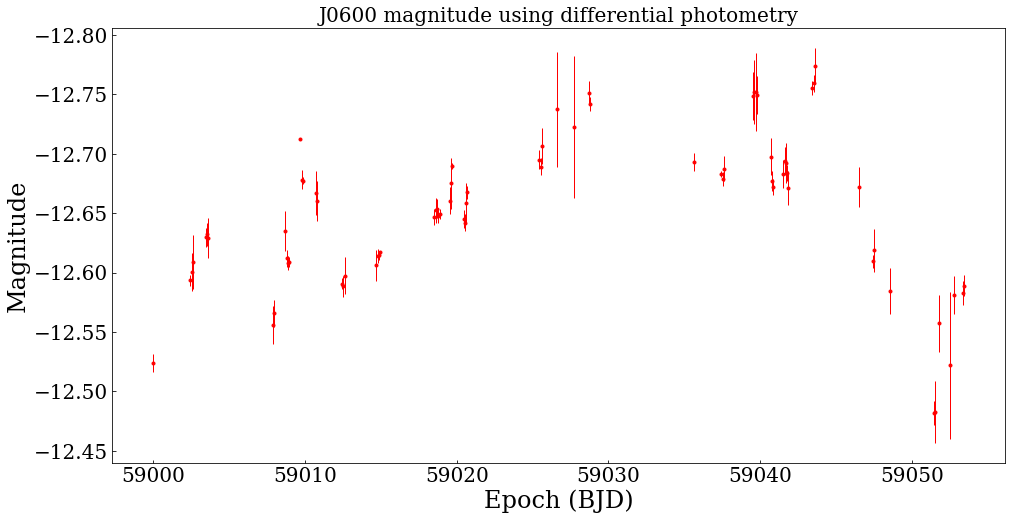

In [66]:
plt.figure(figsize=(12,8))
for s in range(5):
    #plt.plot([corepoch[0],corepoch[-1]], [star_mag[s]]*2,c='black',linestyle='--',linewidth=1)
    #plt.errorbar(corepoch,cormag[:,s]+ZP_real,yerr=cormagerr[:,s],fmt='.')
    plt.errorbar(corepoch+50000,cormag[:,s],yerr=cormagerr[:,s],fmt='.')
plt.gca().invert_yaxis()
plt.title("Reference star mag after binning datapoints together")
plt.xlabel("Epoch (BJD)")
plt.ylabel("$\Delta magnitude$")
plt.show()

fig, axs = plt.subplots(1,2, sharey=True, gridspec_kw={'wspace':0,'width_ratios': [5, 1]})
axs[0].set_title("The reference star magnitude result")
fig.set_figheight(8)
fig.set_figwidth(12)
for s in range(len(cormag[0])):
    axs[0].errorbar(corepoch+50000,cormag[:,s],yerr=cormagerr[:,s],fmt='.')
axs[0].set_ylabel("Offset magnitude")
axs[0].set_xlabel("Epoch[MJD]")
axs[0].set_xlim(corepoch[0]+49998,50002+corepoch[-1])
axs[0].invert_yaxis()
SRT = np.argsort(np.nanmedian(cormag,axis=0))
axs[1].errorbar(final_weight[SRT]/np.max(final_weight),np.nanmedian(cormag,axis=0)[SRT],fmt='--o',c='b')
axs[1].set_xlabel('Relative weighting')
axs[1].set_xlim(-0.05,1.05)

# for s in range(5):
#     #plt.errorbar(corepoch,cormag[:,s]/np.nanmedian(cormag[:,s]),yerr=cormagerr[:,s]/np.nanmedian(cormag[:,s]),fmt='.')
#     plt.errorbar(corepoch,cormag[:,s]/np.nanmedian(cormag[:,s]),fmt='.')
# plt.title("Ref star mag after binning normalised by mean mag")
# plt.xlabel("Epoch (BJD)")
# plt.ylabel("Normalised magnitude")
# plt.show()

plt.figure(figsize=(16,8))
#plt.errorbar(epoch,-2.5*np.log10(J0600_flux/ALC),fmt='.', alpha=0.2)
#plt.errorbar(corepoch,J0600cormag2+ZP_real,yerr=J0600cormagerr2,fmt='.',c='r',linewidth=1)
plt.errorbar(corepoch+50000,J0600cormag2,yerr=J0600cormagerr2,fmt='.',c='r',linewidth=1)
plt.title("J0600 magnitude using differential photometry")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()
#plt.legend(loc=3)
#plt.xlim(9018,9022)
plt.show()

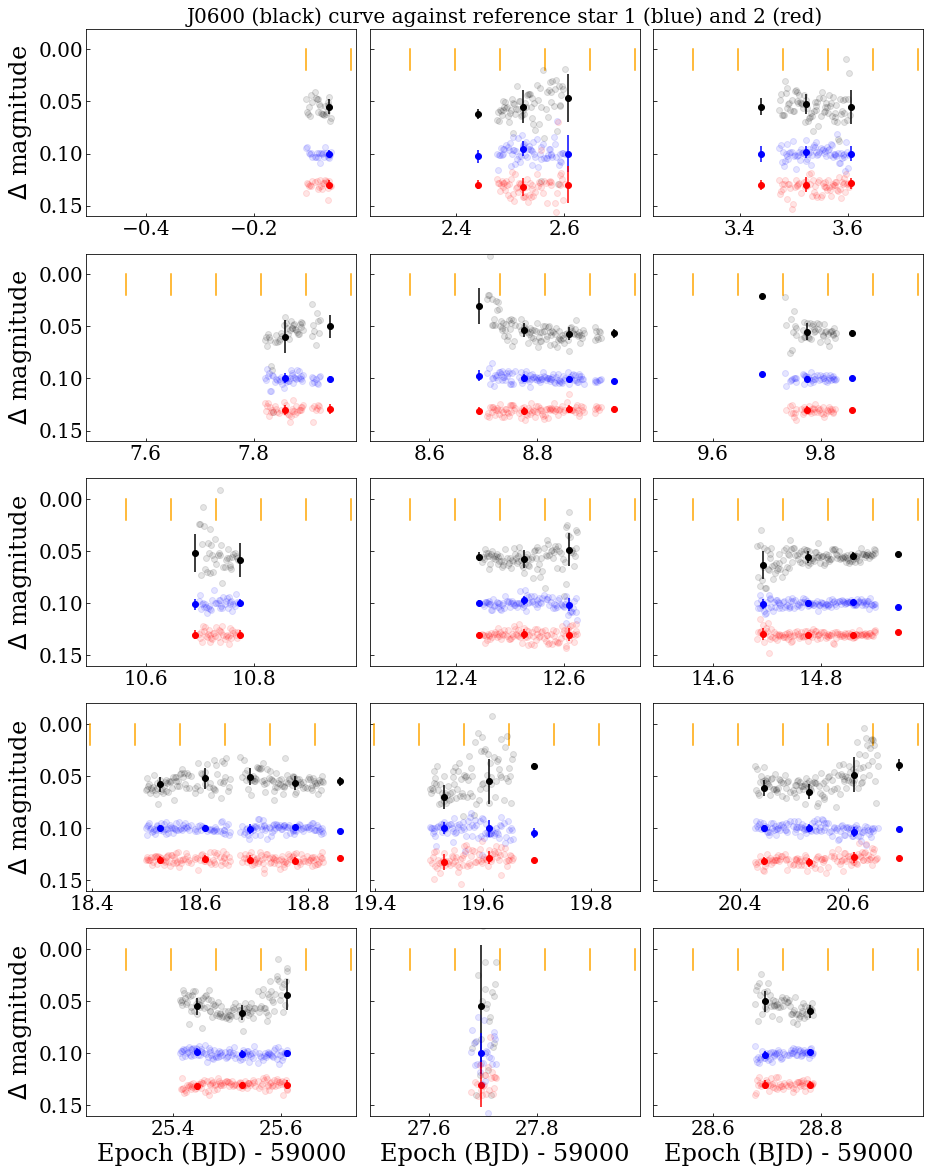

In [86]:
fig, axs = plt.subplots(i_lim,j_lim,gridspec_kw={'hspace': 0.2,'wspace':0.05}, sharey=True)#, 
fig.set_figheight(4*i_lim)
fig.set_figwidth(5*j_lim)
axs[0,1].set_title("J0600 (black) curve against reference star 1 (blue) and 2 (red)")

def windowplt_werr(i,j,x,y,yerr,offset,c,mask):
    axs[i,j].errorbar(x,y - np.nanmedian(y[mask]) + offset,yerr=yerr, fmt='o',c=c)

for i in range(i_lim):
    for j in range(j_lim):
        m1 = corepoch-9000 > lims[i,j,0]
        m2 = corepoch-9000 < lims[i,j,1]
        #windowplt_werr(i,j, corepoch-9000, J0600cormag,J0600cormagerr, 0.055, 'black', m1*m2)
        windowplt_werr(i,j, corepoch-9000, J0600cormag2,J0600cormagerr2, 0.055, 'black', m1*m2)
        s = 0
        windowplt_werr(i,j, corepoch-9000, cormag2[:,s], cormagerr2[:,s], 0.10, 'blue', m1*m2)
        s = 1
        windowplt_werr(i,j, corepoch-9000, cormag2[:,s], cormagerr2[:,s], 0.13, 'red', m1*m2)
        
        m3 = epoch-9000 > lims[i,j,0]
        m4 = epoch-9000 < lims[i,j,1]
        windowplt(i,j, epoch-9000, -2.5*np.log10(J0600_flux/ALC_final), 0.055, 'black', m3*m4,0.1)
        s = 0
        windowplt(i,j, epoch-9000, -2.5*np.log10(sigcl_flux[:,s]/ALC_final), 0.10, 'blue', m3*m4,0.1)
        s = 1
        windowplt(i,j, epoch-9000, -2.5*np.log10(sigcl_flux[:,s]/ALC_final), 0.13, 'red', m3*m4,0.1)
        
        for x in range(int((epoch[-1]-epoch[0])*12)):
            axs[i,j].plot([epoch[0]+x/12-9000]*2,[0,.02],c='orange')
        
        #axs[i,j].plot(epoch-9000,-2.5*np.log10(J0600_flux/ALC)-np.nanmedian((-2.5*np.log10(J0600_flux/ALC))[m1*m2])+0.03,
        #         marker='.',linestyle='',markersize=10,c='r')
        #s = 0
        #axs[i,j].plot(epoch-9000,-2.5*np.log10(flux[:,s]/ALC)-np.nanmedian((-2.5*np.log10(flux[:,s]/ALC))[m1*m2])+0.08,
        #         marker='.',linestyle='',markersize=10,c='blue')
        #s = 1
        #axs[i,j].plot(epoch-9000,-2.5*np.log10(flux[:,s]/ALC)-np.nanmedian((-2.5*np.log10(flux[:,s]/ALC))[m1*m2])+0.12,
        #         marker='.',linestyle='',markersize=10,c='orange')
        
        axs[i,j].set_xlim(lims[i,j])
        axs[i,j].set_ylim([-.02,0.16])
        #axs[i,j].set_ylim([-0.05,0.35])
        axs[i,j].invert_yaxis()
        
        if j == 0:
            axs[i,j].set_ylabel('$\Delta$ magnitude')
        if i == i_lim-1:
            axs[i,j].set_xlabel('Epoch (BJD) - 59000')

#for ax in axs.flat:
#    ax.set(xlabel='Epoch (BJD)', ylabel='$\Delta$ magnitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

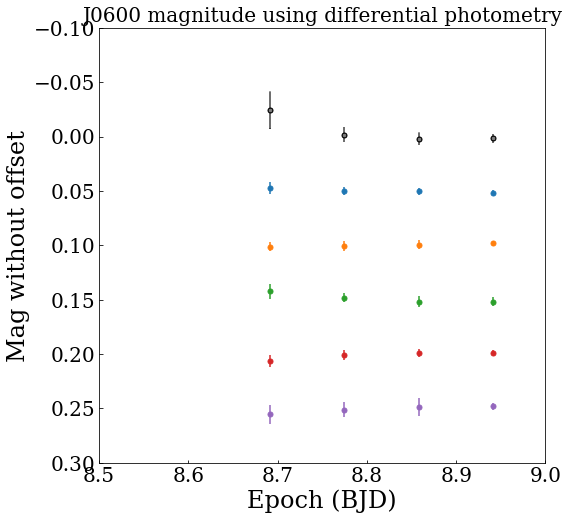

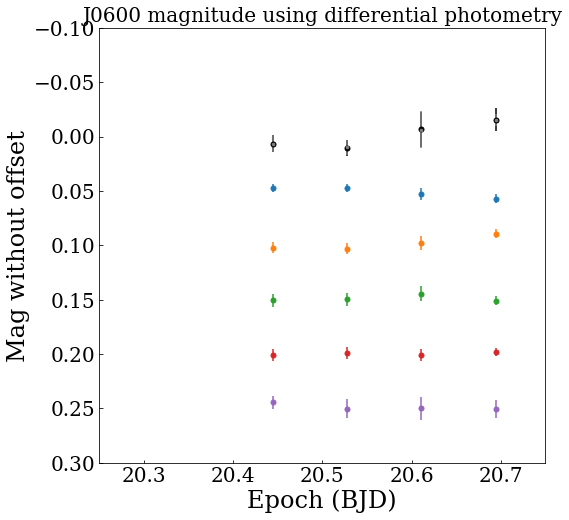

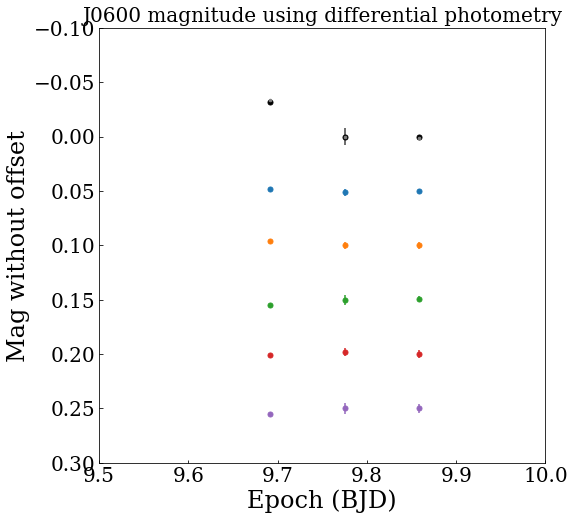

In [30]:
#i,j = 1,1
for N in [[1,1],[3,2],[1,2]]:
    i,j = N
    m1 = corepoch-9000 > lims[i,j,0]
    m2 = corepoch-9000 < lims[i,j,1]

    plt.figure(figsize=(8,8))
    plt.errorbar(corepoch-9000,J0600cormag-np.nanmedian(J0600cormag[m1*m2]),yerr=J0600cormagerr,
                     fmt='.',markersize=10,c='black')
    plt.errorbar(corepoch-9000,J0600cormag2-np.nanmedian(J0600cormag2[m1*m2]),yerr=J0600cormagerr2,
                     fmt='.',markersize=5,c='grey')
    for s in range(5):#[0,1,3]:
        plt.errorbar(corepoch-9000,cormag[:,s]-np.nanmedian(cormag[:,s][m1*m2])+0.05*(s+1),yerr=cormagerr[:,s],
                     fmt='.',markersize=10)

    plt.title("J0600 magnitude using differential photometry")
    plt.xlabel("Epoch (BJD)")
    plt.ylabel("Mag without offset")
    plt.xlim(lims[i,j])
    plt.ylim(-0.1,0.3)
    plt.gca().invert_yaxis()
    plt.show()

In [31]:
# Extract the J0600 data to a file

filepath = "../J0600_mag/ASTEP_R.txt"
filecontent = Table([corepoch+50000, J0600cormag, J0600cormagerr],\
                   names=["EPOCH","MAG","MAGERR"])
ascii.write(filecontent, filepath, overwrite=True)